In [12]:
# !pip install opendatasets -i https://pypi.tuna.tsinghua.edu.cn/simple
# !pip install opencv-python -i https://pypi.tuna.tsinghua.edu.cn/simple

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [9]:
import opendatasets as op
# op.download("https://www.kaggle.com/datasets/sinamhd9/chexnet-weights")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: liumingchen
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████| 25.4M/25.4M [00:04<00:00, 5.56MB/s]


In [19]:
train_root = "G:/大学学习/NTU/dataset/COVID-19_cut (train test split)/train"
val_root = "G:/大学学习/NTU/dataset/COVID-19_cut (train test split)/val"
test_root = "G:/大学学习/NTU/dataset/COVID-19_cut (train test split)_2/test"

In [20]:
import os
import numpy as np
import tensorflow as tf
from keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC

In [21]:
batch_size = 8
image_data_generator = ImageDataGenerator(
    rescale=1/255, vertical_flip=False, horizontal_flip=True, zoom_range=0.1, zca_whitening=False, 
    samplewise_center=True, samplewise_std_normalization=True, rotation_range=0.2)
training_dataset = image_data_generator.flow_from_directory(
    train_root, target_size=(224,224), color_mode='rgb', batch_size=batch_size, shuffle=True)
validation_dataset = image_data_generator.flow_from_directory(
    val_root, target_size=(224,224), color_mode='rgb', batch_size=batch_size, shuffle=True)

Found 10672 images belonging to 3 classes.
Found 1523 images belonging to 3 classes.


In [22]:
training_dataset.classes

array([0, 0, 0, ..., 2, 2, 2])

In [23]:
training_dataset.class_indices

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2}

In [24]:
np.asarray(images[0]).shape

(224, 224, 3)

In [25]:
from keras.applications import densenet
from keras.initializers import GlorotNormal
d = densenet.DenseNet121(weights=None, include_top = False, input_shape = (224, 224, 3))

In [26]:
d.output_shape

(None, 7, 7, 1024)

In [27]:
model = tf.keras.layers.Dropout(0.7)(d.output)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.7)(model)
model = tf.keras.layers.Dense(3, kernel_initializer=GlorotNormal(), activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(0.0001), 
                             bias_regularizer=tf.keras.regularizers.l2(0.0001))(model)
model = tf.keras.models.Model(inputs=d.input, outputs=model)
model.load_weights("../chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5", by_name=True, skip_mismatch=True)
for layer in model.layers[:200]:
    layer.trainable = False
for layer in model.layers[200:]:
    layer.trainable = True

In [28]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.categorical_crossentropy, 
              metrics =  [TruePositives(name='tp'),
              FalsePositives(name='fp'),
              TrueNegatives(name='tn'),
              FalseNegatives(name='fn'), 
              'accuracy',
              Precision(name='precision'),
              Recall(name='recall')])

In [29]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

 conv2_block4_0_relu (Activatio  (None, 56, 56, 160)  0          ['conv2_block4_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block10_concat (Concaten  (None, 28, 28, 448)  0          ['conv3_block9_concat[0][0]',    
 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
          

                                                                                                  
 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block7_0_relu (Activatio  (None, 14, 14, 448)  0          ['conv4_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block15_2_conv[0][0]']   
                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_rel

 ization)                                                                                         
                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_blo

 conv5_block8_concat (Concatena  (None, 7, 7, 768)   0           ['conv5_block7_concat[0][0]',    
 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
          

 on)                                                                                              
                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

                                                                                                  
 dense_2 (Dense)                (None, 3)            3075        ['dropout_5[0][0]']              
                                                                                                  
Total params: 7,040,579
Trainable params: 4,781,059
Non-trainable params: 2,259,520
__________________________________________________________________________________________________


In [30]:
model.layers[199]

In [31]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min'),
    #tf.keras.callbacks.ModelCheckpoint(filepath='model_{epoch:02d}-{val_accuracy:.2f}.hdf5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [32]:
history = model.fit(training_dataset, batch_size=batch_size, validation_data=validation_dataset, epochs=30, callbacks=my_callbacks)

Epoch 1/30
1334/1334 [==============================] - 215s 153ms/step - loss: 0.5468 - tp: 8135.0000 - fp: 1895.0000 - tn: 19449.0000 - fn: 2537.0000 - accuracy: 0.7871 - precision: 0.8111 - recall: 0.7623 - val_loss: 0.2734 - val_tp: 1347.0000 - val_fp: 142.0000 - val_tn: 2904.0000 - val_fn: 176.0000 - val_accuracy: 0.8949 - val_precision: 0.9046 - val_recall: 0.8844 - lr: 0.0010
Epoch 2/30
1334/1334 [==============================] - 200s 150ms/step - loss: 0.3775 - tp: 9110.0000 - fp: 1366.0000 - tn: 19978.0000 - fn: 1562.0000 - accuracy: 0.8613 - precision: 0.8696 - recall: 0.8536 - val_loss: 0.2368 - val_tp: 1383.0000 - val_fp: 122.0000 - val_tn: 2924.0000 - val_fn: 140.0000 - val_accuracy: 0.9133 - val_precision: 0.9189 - val_recall: 0.9081 - lr: 0.0010
Epoch 3/30
1334/1334 [==============================] - 199s 149ms/step - loss: 0.3228 - tp: 9383.0000 - fp: 1148.0000 - tn: 20196.0000 - fn: 1289.0000 - accuracy: 0.8858 - precision: 0.8910 - recall: 0.8792 - val_loss: 0.2212 -

Epoch 18: early stopping


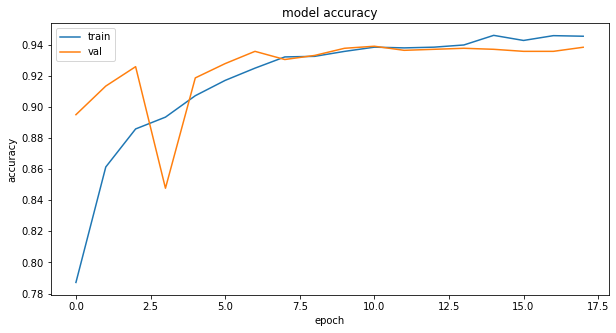

In [33]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

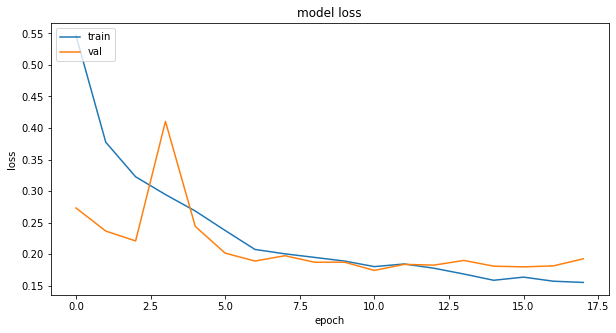

In [34]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
test_dataset = image_data_generator.flow_from_directory(test_root, target_size=(224,224), color_mode='rgb', batch_size=batch_size, shuffle=False)

Found 2168 images belonging to 3 classes.


271/271 [==============================] - 21s 76ms/step
[0 0 0 ... 2 2 2]


<AxesSubplot:>

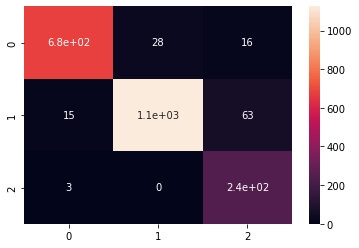

In [45]:
import seaborn as sns
predict_x = model.predict(test_dataset) 
pred = np.argmax(predict_x,axis=1)
print(pred)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_dataset.classes, pred)
sns.heatmap(cm, annot=True)


In [37]:
print(cm)

[[ 685   24   15]
 [  22 1125   56]
 [   4    0  237]]


<AxesSubplot:>

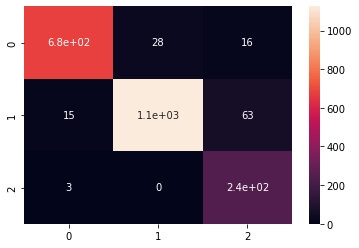

In [52]:
cm = confusion_matrix(test_dataset.classes, pred)
sns.heatmap(cm, annot=True)

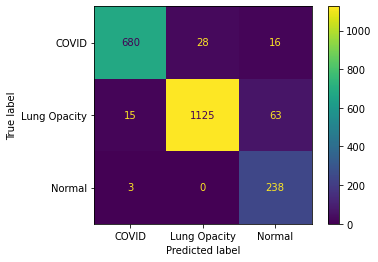

In [51]:
cm2 = ConfusionMatrixDisplay(cm, display_labels=('COVID','Lung Opacity','Normal'))
cm2.plot()
plt.show()

In [57]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, pred,target_names=['COVID','Lung Opacity','Normal']))

              precision    recall  f1-score   support

       COVID       0.97      0.94      0.96       724
Lung Opacity       0.98      0.94      0.96      1203
      Normal       0.75      0.99      0.85       241

    accuracy                           0.94      2168
   macro avg       0.90      0.95      0.92      2168
weighted avg       0.95      0.94      0.94      2168



In [55]:
help(classification_report)

Help on function classification_report in module sklearn.metrics._classification:

classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')
    Build a text report showing the main classification metrics.
    
    Read more in the :ref:`User Guide <classification_report>`.
    
    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.
    
    y_pred : 1d array-like, or label indicator array / sparse matrix
        Estimated targets as returned by a classifier.
    
    labels : array-like of shape (n_labels,), default=None
        Optional list of label indices to include in the report.
    
    target_names : list of str of shape (n_labels,), default=None
        Optional display names matching the labels (same order).
    
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.

In [53]:
print((cm[0,0]+cm[1,1]+cm[2,2])/(sum(sum(cm))))

0.9423431734317343


In [39]:
model.evaluate(test_dataset, batch_size=batch_size)

271/271 [==============================] - 23s 83ms/step - loss: 0.1783 - tp: 2023.0000 - fp: 135.0000 - tn: 4201.0000 - fn: 145.0000 - accuracy: 0.9350 - precision: 0.9374 - recall: 0.9331


[0.17834046483039856,
 2023.0,
 135.0,
 4201.0,
 145.0,
 0.9349631071090698,
 0.9374420642852783,
 0.9331181049346924]

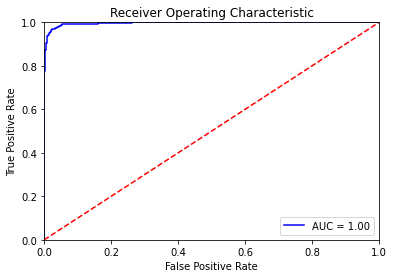

In [63]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = predict_x
# print(probs)
# print(probs.shape)
preds = probs[:,0]
# print(preds)
# print(preds.shape)
# print(test_data.classes.shape)
fpr, tpr, threshold = metrics.roc_curve(test_dataset.classes, preds, pos_label=0)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()